# Task
Please provide the exact column names for:
1. The city code in the population dataset.
2. The city code in the cities dataset.
3. The column in the population dataset that needs filtering to drop rows containing '2019'.

## Ask for specific column names

### Subtask:
Clarify the exact column names for the city code in both datasets and the 'Any' column in the population dataset.


### Clarify column names

Please provide the exact column names for:
1. The city code in the population dataset.
2. The city code in the cities dataset.
3. The column in the population dataset that needs filtering to drop rows containing '2019' (This is probably the 'Year' or 'Date' column).


## Identify and provide specific column names

### Subtask:
Load the population and cities datasets, and then identify the exact column names for the city code in both datasets, and the column in the population dataset that needs filtering to drop rows containing '2019'.


**Reasoning**:
The first step is to import the pandas library to work with DataFrames and then load the two specified CSV files into pandas DataFrames named `df_population` and `df_cities`.



In [63]:
import pandas as pd

df_population = pd.read_csv('/content/Població_de_Catalunya_per_municipi,_rang_d\'edat_i_sexe_20251108.csv')
df_cities = pd.read_csv('/content/Municipis_Catalunya_Geo_20251108.csv')

print("Population DataFrame columns:")
print(df_population.columns)
print("\nCities DataFrame columns:")
print(df_cities.columns)

Population DataFrame columns:
Index(['Any', 'Codi', 'Nom', 'Homes. De 0 a 14 anys', 'Homes. De 15 a 64 anys',
       'Homes. De 65 anys i més', 'Dones. De 0 a 14 anys',
       'Dones. De 15 a 64 anys', 'Dones. De 65 anys i més',
       'Total. De 0 a 14 anys', 'Total. De 15 a 64 anys',
       'Total. De 65 anys i més'],
      dtype='object')

Cities DataFrame columns:
Index(['Codi', 'Nom', 'Codi comarca', 'Nom comarca', 'UTM X', 'UTM Y',
       'Longitud', 'Latitud', 'Georeferència'],
      dtype='object')


### Identified Column Names:

1.  **City code in `df_population`**: `Codi`
2.  **City code in `df_cities`**: `Codi`
3.  **Column in `df_population` that needs filtering for '2019'**: `Any`

## Load and Preprocess Data

### Subtask:
Filter the population DataFrame to drop rows where the 'Any' column contains '2019' and then merge the two DataFrames based on the common city code column.


**Reasoning**:
First, filter the `df_population` DataFrame to exclude rows where the 'Any' column is '2019'. Then, merge the filtered `df_population` with `df_cities` on the 'Codi' column using an inner join. Finally, display the head and info of the merged DataFrame to verify the operations.



In [64]:
df_population = df_population[df_population['Any'] != 2019]

df_merged = pd.merge(df_population, df_cities, on='Codi', how='inner')

# Convert 'Total. De 15 a 64 anys' to numeric, handling potential string issues
df_merged['Total. De 15 a 64 anys'] = df_merged['Total. De 15 a 64 anys'].astype(str).str.replace('.', '', regex=False).astype(float)
df_merged['UTM X'] = df_merged['UTM X'].str.replace(',', '').astype(float)
df_merged['UTM Y'] = df_merged['UTM Y'].str.replace(',', '').astype(float)

print("First 5 rows of the merged DataFrame:")
print(df_merged.head())

print("\nInformation about the merged DataFrame:")
df_merged.info()

First 5 rows of the merged DataFrame:
    Any    Codi                   Nom_x  Homes. De 0 a 14 anys  \
0  2020   80057  Ametlla del Vallès, l'                717.000   
1  2020  250019      Abella de la Conca                 11.000   
2  2020   80018                  Abrera                  1.164   
3  2020  250024                    Àger                 25.000   
4  2020  250030                Agramunt                415.000   

   Homes. De 15 a 64 anys  Homes. De 65 anys i més  Dones. De 0 a 14 anys  \
0                   3.018                    623.0                663.000   
1                  67.000                     21.0                  7.000   
2                   4.274                    887.0                  1.072   
3                 200.000                     89.0                 26.000   
4                   1.807                    488.0                422.000   

   Dones. De 15 a 64 anys  Dones. De 65 anys i més  Total. De 0 a 14 anys  \
0                   2.946

## Build Graph

### Subtask:
Initialize a NetworkX graph. Add each city as a node, incorporating relevant data like population and coordinates. Calculate the Euclidean distance between all unique pairs of cities using their 'UTM X' and 'UTM Y' coordinates. For any pair of cities less than 50km apart, add a weighted edge to the graph, with the weight being the distance.


**Reasoning**:
The first step is to import the necessary libraries, NetworkX for graph operations and NumPy for numerical calculations. Then, I will initialize an empty graph object. After that, I will convert the 'UTM X' and 'UTM Y' columns to a numeric format by first removing commas and then casting them to float, which is crucial for distance calculations. Finally, I will iterate through the DataFrame to add each city as a node to the graph with its relevant attributes.



In [65]:
import networkx as nx
import numpy as np

G = nx.Graph()

# Add nodes to the graph
for index, row in df_merged.iterrows():
    G.add_node(row['Codi'],
               name=row['Nom_x'],
               pop_0_14=row['Total. De 0 a 14 anys'],
               pop_15_64=row['Total. De 15 a 64 anys'],
               pop_65_plus=row['Total. De 65 anys i més'],
               utm_x=row['UTM X'],
               utm_y=row['UTM Y'])

print(f"Graph initialized with {G.number_of_nodes()} nodes.")

Graph initialized with 947 nodes.


**Reasoning**:
Now that the nodes are added to the graph, I will iterate through all unique pairs of cities to calculate the Euclidean distance between them. If the distance is less than 50,000 meters (50 km), I will add a weighted edge to the graph. Finally, I will print the number of edges added to confirm the operation.



In [66]:
for i, (node1, data1) in enumerate(G.nodes(data=True)):
    for j, (node2, data2) in enumerate(G.nodes(data=True)):
        if i < j: # Ensure unique pairs and avoid self-loops
            # Retrieve UTM coordinates
            utm_x1, utm_y1 = data1['utm_x'], data1['utm_y']
            utm_x2, utm_y2 = data2['utm_x'], data2['utm_y']

            # Calculate Euclidean distance
            distance = np.sqrt((utm_x1 - utm_x2)**2 + (utm_y1 - utm_y2)**2)


            # Add edge if distance is less than 50km (50000 meters)
            if distance < 10000:
                G.add_edge(node1, node2, weight=distance)

print(f"Graph now has {G.number_of_edges()} edges.")

Graph now has 5423 edges.


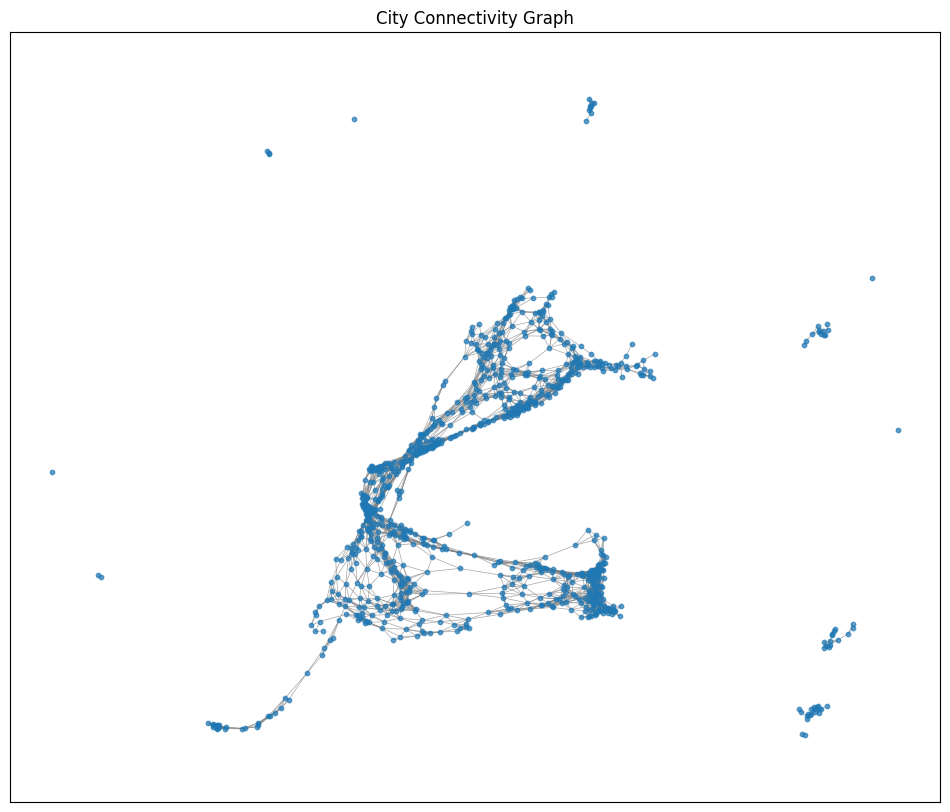

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, k=0.1, iterations=50), # Use spring layout for better visualization, adjust k and iterations as needed
    with_labels=False,
    node_size=10,
    width=0.5,
    alpha=0.7,
    edge_color='gray'
)
plt.title('City Connectivity Graph')
plt.show()

# Lleida

Filter the `df_merged` DataFrame to include only cities belonging to the Lleida province by selecting rows where the 'Nom comarca' column matches any of the specified comarcas: 'Alta Ribagorça', 'Alt Urgell', 'Cerdanya', 'Garrigues', 'Noguera', 'Pallars Jussà', 'Pallars Sobirà', 'Pla d\'Urgell', 'Segarra', 'Segrià', 'Solsonès', 'Urgell', 'Val d\'Aran'.

## Filter Data for Lleida Province

### Subtask:
Filter the merged DataFrame (`df_merged`) to select only the cities belonging to the specified 'Comarca' for the Lleida province: 'Alta Ribagorça', 'Alt Urgell', 'Cerdanya', 'Garrigues', 'Noguera', 'Pallars Jussà', 'Pallars Sobirà', 'Pla d'Urgell', 'Segarra', 'Segrià', 'Solsonès', 'Urgell', 'Val d'Aran'.


**Reasoning**:
First, I'll create a list of the specified 'Comarca' names for Lleida province. Then, I will filter the `df_merged` DataFrame to include only these comarcas, storing the result in a new DataFrame called `df_lleida`. Finally, I'll display the head and shape of `df_lleida` to verify the filtering.



In [68]:
lleida_comarcas = [
    'Alta Ribagorça',
    'Alt Urgell',
    'Cerdanya',
    'Garrigues',
    'Noguera',
    'Pallars Jussà',
    'Pallars Sobirà',
    "Pla d'Urgell",
    'Segarra',
    'Segrià',
    'Solsonès',
    'Urgell',
    "Val d'Aran"
]

df_lleida = df_merged[df_merged['Nom comarca'].isin(lleida_comarcas)]

print("First 5 rows of df_lleida:")
print(df_lleida.head())

print(f"\nShape of df_lleida: {df_lleida.shape}")

First 5 rows of df_lleida:
     Any    Codi               Nom_x  Homes. De 0 a 14 anys  \
1   2020  250019  Abella de la Conca                   11.0   
3   2020  250024                Àger                   25.0   
4   2020  250030            Agramunt                  415.0   
10  2020  250387              Aitona                  215.0   
11  2020  250045         Alamús, els                   56.0   

    Homes. De 15 a 64 anys  Homes. De 65 anys i més  Dones. De 0 a 14 anys  \
1                   67.000                     21.0                    7.0   
3                  200.000                     89.0                   26.0   
4                    1.807                    488.0                  422.0   
10                 871.000                    252.0                  188.0   
11                 272.000                     84.0                   50.0   

    Dones. De 15 a 64 anys  Dones. De 65 anys i més  Total. De 0 a 14 anys  \
1                   54.000                     

## Build Lleida Province Graph

### Subtask:
Initialize a new NetworkX graph specifically for the Lleida province. Add each city from the filtered Lleida DataFrame as a node, incorporating its name, population data, and UTM coordinates. Then, iterate through all unique pairs of cities in the Lleida graph, calculate the Euclidean distance between them, and add a weighted edge if the distance is less than 50,000 meters (50km).


**Reasoning**:
Initialize an empty NetworkX graph and add nodes from the `df_lleida` DataFrame, including relevant city information as node attributes.



In [69]:
import networkx as nx
import numpy as np

G_lleida = nx.Graph()

# Add nodes to the graph from df_lleida
for index, row in df_lleida.iterrows():
    G_lleida.add_node(row['Codi'],
               name=row['Nom_x'],
               pop_0_14=row['Total. De 0 a 14 anys'],
               pop_15_64=row['Total. De 15 a 64 anys'],
               pop_65_plus=row['Total. De 65 anys i més'],
               utm_x=row['UTM X'],
               utm_y=row['UTM Y'])

print(f"Lleida graph initialized with {G_lleida.number_of_nodes()} nodes.")

Lleida graph initialized with 232 nodes.


**Reasoning**:
Now that the nodes have been added to the `G_lleida` graph, the next step is to iterate through all unique pairs of cities, calculate the Euclidean distance between them, and add a weighted edge if the distance is less than 50,000 meters (50km) as specified in the instructions. Finally, the number of edges in `G_lleida` will be printed to confirm the operation.



In [70]:
for i, (node1, data1) in enumerate(G_lleida.nodes(data=True)):
    for j, (node2, data2) in enumerate(G_lleida.nodes(data=True)):
        if i < j: # Ensure unique pairs and avoid self-loops
            # Retrieve UTM coordinates
            utm_x1, utm_y1 = data1['utm_x'], data1['utm_y']
            utm_x2, utm_y2 = data2['utm_x'], data2['utm_y']

            # Calculate Euclidean distance
            distance = np.sqrt((utm_x1 - utm_x2)**2 + (utm_y1 - utm_y2)**2)

            # Add edge if distance is less than 50km (50000 meters)
            if distance < 15000:
                G_lleida.add_edge(node1, node2, weight=distance)

print(f"Lleida graph now has {G_lleida.number_of_edges()} edges.")

Lleida graph now has 1800 edges.


## Visualize Lleida Province Graph

### Subtask:
Display the generated NetworkX graph for the Lleida province using matplotlib, similar to the previous visualization, to show its structure and connectivity.


**Reasoning**:
To visualize the Lleida province graph, I will use `matplotlib.pyplot` and `networkx` to draw the graph with specified aesthetic parameters.



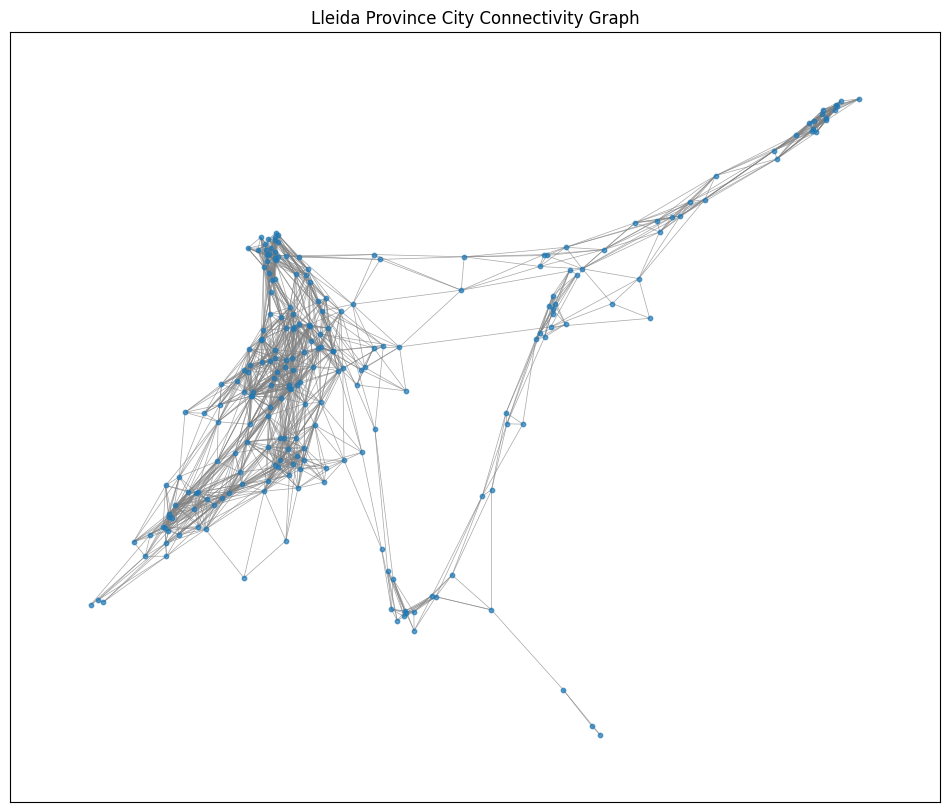

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
nx.draw_networkx(
    G_lleida,
    pos=nx.spring_layout(G_lleida, k=0.1, iterations=50), # Use spring layout for better visualization, adjust k and iterations as needed
    with_labels=False,
    node_size=10,
    width=0.5,
    alpha=0.7,
    edge_color='gray'
)
plt.title('Lleida Province City Connectivity Graph')
plt.show()

# Girona
Filter the merged DataFrame (`df_merged`) to select only the cities belonging to the specified 'Comarca' for the Girona province: 'Alt Empordà', 'Baix Empordà', 'Garrotxa', 'Gironès', 'Pla de l'Estany', 'Ripollès', 'Selva'.

## Filter Data for Girona Province

### Subtask:
Filter the merged DataFrame (`df_merged`) to select only the cities belonging to the specified 'Comarca' for the Girona province: 'Alt Empordà', 'Baix Empordà', 'Garrotxa', 'Gironès', 'Pla de l'Estany', 'Ripollès', 'Selva'.


**Reasoning**:
First, I'll define a list of comarcas belonging to the Girona province. Then, I will filter the `df_merged` DataFrame to include only these comarcas, storing the result in a new DataFrame called `df_girona`. Finally, I'll display the head and shape of `df_girona` to verify the filtering.



In [72]:
girona_comarcas = [
    'Alt Empordà',
    'Baix Empordà',
    'Garrotxa',
    'Gironès',
    "Pla de l'Estany",
    'Ripollès',
    'Selva'
]

df_girona = df_merged[df_merged['Nom comarca'].isin(girona_comarcas)]

print("First 5 rows of df_girona:")
print(df_girona.head())

print(f"\nShape of df_girona: {df_girona.shape}")

First 5 rows of df_girona:
     Any    Codi      Nom_x  Homes. De 0 a 14 anys  Homes. De 15 a 64 anys  \
6   2020  170010   Agullana                   67.0                   275.0   
9   2020  170025  Aiguaviva                   75.0                   254.0   
14  2020  170031    Albanyà                   18.0                    47.0   
20  2020  170046     Albons                   53.0                   262.0   
48  2020  170078       Amer                  156.0                   737.0   

    Homes. De 65 anys i més  Dones. De 0 a 14 anys  Dones. De 15 a 64 anys  \
6                      89.0                   68.0                   270.0   
9                      56.0                   64.0                   257.0   
14                     14.0                   19.0                    46.0   
20                     76.0                   54.0                   242.0   
48                    251.0                  155.0                   716.0   

    Dones. De 65 anys i més  Total.

## Build Girona Province Graph

### Subtask:
Initialize a new NetworkX graph specifically for the Girona province. Add each city from the filtered Girona DataFrame as a node, incorporating its name, population data, and UTM coordinates. Then, iterate through all unique pairs of cities in the Girona graph, calculate the Euclidean distance between them, and add a weighted edge if the distance is less than 50,000 meters (50km).

**Reasoning**:
To begin building the graph for the Girona province, I need to initialize an empty NetworkX graph and then populate it with nodes from the `df_girona` DataFrame. Each node will represent a city and will store relevant attributes like its name, population data, and UTM coordinates for later distance calculations.



In [73]:
import networkx as nx
import numpy as np

G_girona = nx.Graph()

# Add nodes to the graph from df_girona
for index, row in df_girona.iterrows():
    G_girona.add_node(row['Codi'],
               name=row['Nom_x'],
               pop_0_14=row['Total. De 0 a 14 anys'],
               pop_15_64=row['Total. De 15 a 64 anys'],
               pop_65_plus=row['Total. De 65 anys i més'],
               utm_x=row['UTM X'],
               utm_y=row['UTM Y'])

print(f"Girona graph initialized with {G_girona.number_of_nodes()} nodes.")

Girona graph initialized with 208 nodes.


**Reasoning**:
Now that the nodes have been added to the `G_girona` graph, the next step is to iterate through all unique pairs of cities, calculate the Euclidean distance between them, and add a weighted edge if the distance is less than 50,000 meters (50km) as specified in the instructions. Finally, the number of edges in `G_girona` will be printed to confirm the operation.



In [74]:
for i, (node1, data1) in enumerate(G_girona.nodes(data=True)):
    for j, (node2, data2) in enumerate(G_girona.nodes(data=True)):
        if i < j: # Ensure unique pairs and avoid self-loops
            # Retrieve UTM coordinates
            utm_x1, utm_y1 = data1['utm_x'], data1['utm_y']
            utm_x2, utm_y2 = data2['utm_x'], data2['utm_y']

            # Calculate Euclidean distance
            distance = np.sqrt((utm_x1 - utm_x2)**2 + (utm_y1 - utm_y2)**2)

            # Add edge if distance is less than 50km (50000 meters)
            if distance < 15000:
                G_girona.add_edge(node1, node2, weight=distance)

print(f"Girona graph now has {G_girona.number_of_edges()} edges.")

Girona graph now has 2918 edges.


## Visualize Girona Province Graph

### Subtask:
Display the generated NetworkX graph for the Girona province using matplotlib, similar to the previous visualization, to show its structure and connectivity.

**Reasoning**:
To visualize the Girona province graph, I will use `matplotlib.pyplot` and `networkx` to draw the graph with specified aesthetic parameters, similar to the previous visualizations.



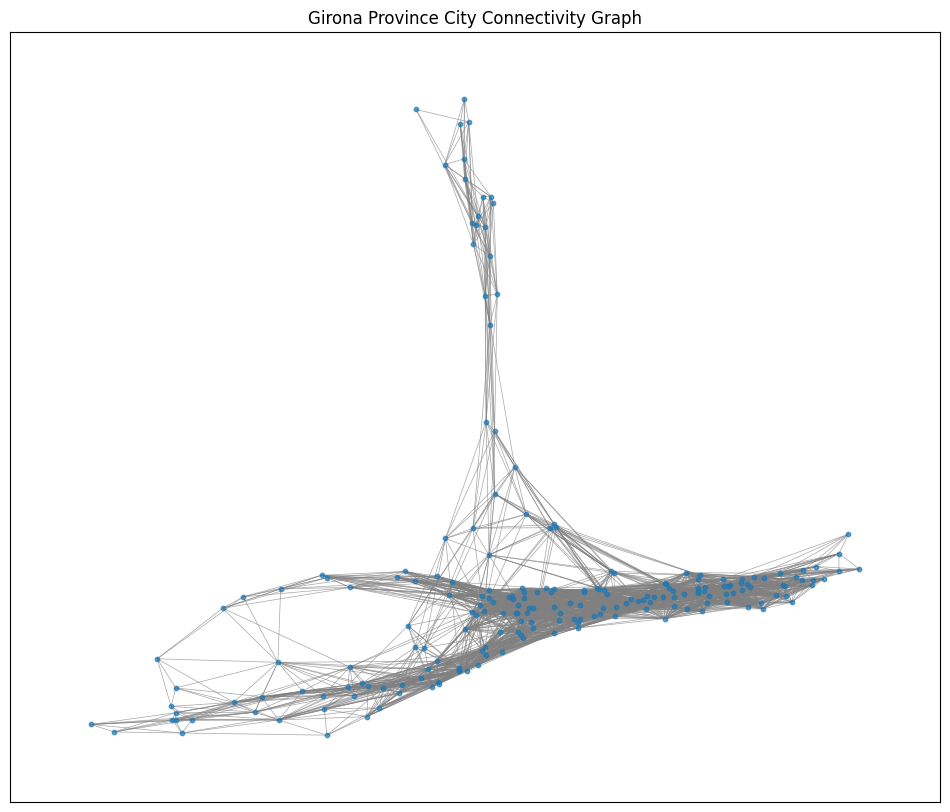

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
nx.draw_networkx(
    G_girona,
    pos=nx.spring_layout(G_girona, k=0.1, iterations=50), # Use spring layout for better visualization, adjust k and iterations as needed
    with_labels=False,
    node_size=10,
    width=0.5,
    alpha=0.7,
    edge_color='gray'
)
plt.title('Girona Province City Connectivity Graph')
plt.show()

# Task
Filter the `df_merged` DataFrame to include only cities belonging to the Tarragona province by selecting rows where the 'Nom comarca' column matches any of the specified comarcas: 'Alt Camp', 'Baix Camp', 'Baix Ebre', 'Baix Penedès', 'Conca de Barberà', 'Ribera d'Ebre', 'Montsià', 'Priorat', 'Tarragonès', 'Terra Alta'. Then, build a NetworkX graph for the filtered Tarragona data, adding each city as a node with its name, population, and UTM coordinates. Calculate the Euclidean distance between all unique city pairs and add a weighted edge if the distance is less than 50,000 meters (50km). Finally, visualize the created graph using `matplotlib` and present the graph structure, including the number of nodes and edges, along with a summary of its creation process.

## Filter Data for Tarragona Province

### Subtask:
Filter the merged DataFrame (`df_merged`) to select only the cities belonging to the specified 'Comarca' for the Tarragona province: 'Alt Camp', 'Baix Camp', 'Baix Ebre', 'Baix Penedès', 'Conca de Barberà', 'Ribera d'Ebre', 'Montsià', 'Priorat', 'Tarragonès', 'Terra Alta'.


**Reasoning**:
First, I'll define a list of comarcas belonging to the Tarragona province. Then, I will filter the `df_merged` DataFrame to include only these comarcas, storing the result in a new DataFrame called `df_tarragona`. Finally, I'll display the head and shape of `df_tarragona` to verify the filtering.



In [76]:
tarragona_comarcas = [
    'Alt Camp',
    'Baix Camp',
    'Baix Ebre',
    'Baix Penedès',
    'Conca de Barberà',
    'Ribera d\'Ebre',
    'Montsià',
    'Priorat',
    'Tarragonès',
    'Terra Alta'
]

df_tarragona = df_merged[df_merged['Nom comarca'].isin(tarragona_comarcas)]

print("First 5 rows of df_tarragona:")
print(df_tarragona.head())

print(f"\nShape of df_tarragona: {df_tarragona.shape}")

First 5 rows of df_tarragona:
     Any    Codi        Nom_x  Homes. De 0 a 14 anys  Homes. De 15 a 64 anys  \
8   2020  430017  Aiguamúrcia                   59.0                 310.000   
18  2020  430022    Albinyana                  193.0                 865.000   
19  2020  430038   Albiol, l'                   66.0                 167.000   
21  2020  430043      Alcanar                  665.0                   3.176   
25  2020  430056      Alcover                  424.0                   1.715   

    Homes. De 65 anys i més  Dones. De 0 a 14 anys  Dones. De 15 a 64 anys  \
8                     114.0                   68.0                 272.000   
18                    215.0                  163.0                 765.000   
19                     39.0                   40.0                 157.000   
21                    941.0                  642.0                   2.933   
25                    416.0                  441.0                   1.644   

    Dones. De 65 any

**Reasoning**:
To begin building the graph for the Tarragona province, I need to initialize an empty NetworkX graph and then populate it with nodes from the `df_tarragona` DataFrame. Each node will represent a city and will store relevant attributes like its name, population data, and UTM coordinates for later distance calculations.



In [77]:
import networkx as nx
import numpy as np

G_tarragona = nx.Graph()

# Add nodes to the graph from df_tarragona
for index, row in df_tarragona.iterrows():
    G_tarragona.add_node(row['Codi'],
               name=row['Nom_x'],
               pop_0_14=row['Total. De 0 a 14 anys'],
               pop_15_64=row['Total. De 15 a 64 anys'],
               pop_65_plus=row['Total. De 65 anys i més'],
               utm_x=row['UTM X'],
               utm_y=row['UTM Y'])

print(f"Tarragona graph initialized with {G_tarragona.number_of_nodes()} nodes.")

Tarragona graph initialized with 184 nodes.


**Reasoning**:
Now that the nodes have been added to the `G_tarragona` graph, the next step is to iterate through all unique pairs of cities, calculate the Euclidean distance between them, and add a weighted edge if the distance is less than 50,000 meters (50km) as specified in the instructions. Finally, the number of edges in `G_tarragona` will be printed to confirm the operation.



In [78]:
for i, (node1, data1) in enumerate(G_tarragona.nodes(data=True)):
    for j, (node2, data2) in enumerate(G_tarragona.nodes(data=True)):
        if i < j: # Ensure unique pairs and avoid self-loops
            # Retrieve UTM coordinates
            utm_x1, utm_y1 = data1['utm_x'], data1['utm_y']
            utm_x2, utm_y2 = data2['utm_x'], data2['utm_y']

            # Calculate Euclidean distance
            distance = np.sqrt((utm_x1 - utm_x2)**2 + (utm_y1 - utm_y2)**2)

            # Add edge if distance is less than 50km (50000 meters)
            if distance < 15000:
                G_tarragona.add_edge(node1, node2, weight=distance)

print(f"Tarragona graph now has {G_tarragona.number_of_edges()} edges.")

Tarragona graph now has 2005 edges.


**Reasoning**:
To visualize the Tarragona province graph, I will use `matplotlib.pyplot` and `networkx` to draw the graph with specified aesthetic parameters, similar to the previous visualizations.



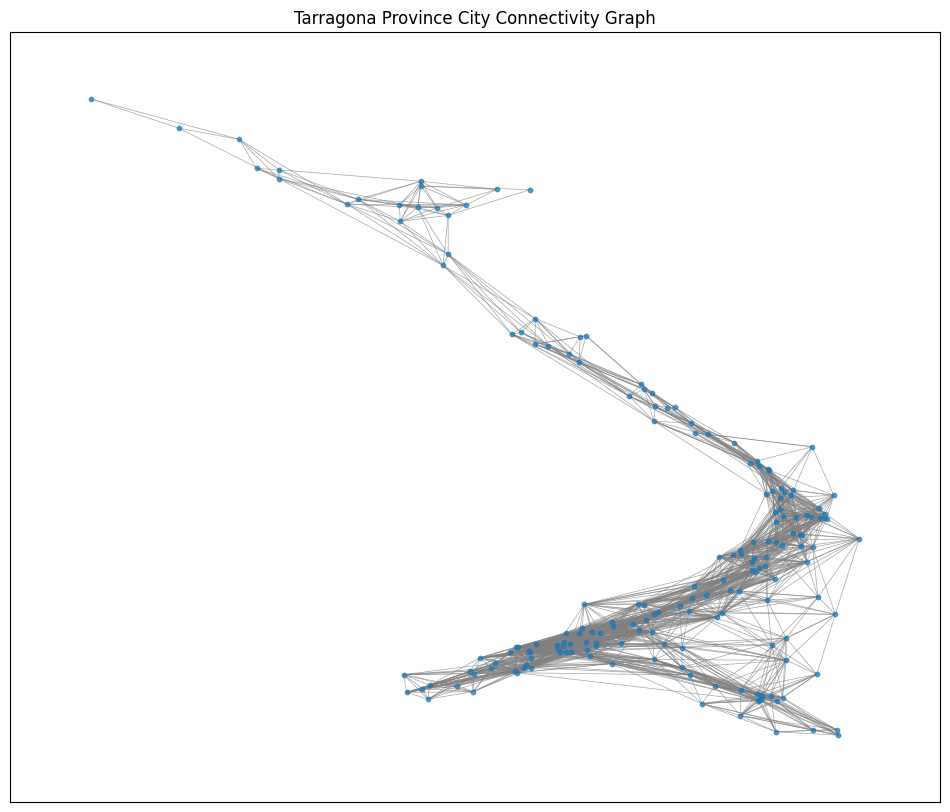

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
nx.draw_networkx(
    G_tarragona,
    pos=nx.spring_layout(G_tarragona, k=0.1, iterations=50), # Use spring layout for better visualization, adjust k and iterations as needed
    with_labels=False,
    node_size=10,
    width=0.5,
    alpha=0.7,
    edge_color='gray'
)
plt.title('Tarragona Province City Connectivity Graph')
plt.show()

# ALGORITHM TO SELECT


In [84]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

class BankCoverageOptimizer:
    """
    Optimizes the placement of physical bank offices and mobile van stops
    to maximize population coverage in rural areas.
    """

    def __init__(self, graph, physical_office_radius=15000, mobile_van_radius=10000):
        """
        Initialize the optimizer.

        Parameters:
        - graph: NetworkX graph with nodes containing population and coordinates
        - physical_office_radius: Coverage radius for physical offices (meters)
        - mobile_van_radius: Coverage radius for mobile van stops (meters)
        """
        self.G = graph
        self.physical_office_radius = physical_office_radius
        self.mobile_van_radius = mobile_van_radius

        # Initialize all nodes as uncovered
        for node in self.G.nodes():
            self.G.nodes[node]['node_type'] = 'uncovered'
            self.G.nodes[node]['covered_by'] = []
            self.G.nodes[node]['coverage_score'] = 0

    def get_total_population(self, node):
        """Get total population of a node across all age groups."""
        data = self.G.nodes[node]
        pop_0_14 = data.get('pop_0_14', 0)
        pop_15_64 = data.get('pop_15_64', 0)
        pop_65_plus = data.get('pop_65_plus', 0)
        return pop_0_14 + pop_15_64 + pop_65_plus

    def calculate_distance(self, node1, node2):
        """Calculate Euclidean distance between two nodes."""
        data1 = self.G.nodes[node1]
        data2 = self.G.nodes[node2]

        x1, y1 = data1['utm_x'], data1['utm_y']
        x2, y2 = data2['utm_x'], data2['utm_y']

        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def get_nodes_within_radius(self, center_node, radius):
        """Get all nodes within a given radius of the center node."""
        nodes_in_radius = []

        for node in self.G.nodes():
            if node == center_node:
                nodes_in_radius.append(node)
            else:
                distance = self.calculate_distance(center_node, node)
                if distance <= radius:
                    nodes_in_radius.append(node)

        return nodes_in_radius

    def calculate_coverage_score(self, node, radius, already_covered=None):
        """
        Calculate coverage score for a potential facility location.
        Score = weighted sum of uncovered population within radius.
        Closer nodes get higher weight.
        """
        if already_covered is None:
            already_covered = set()

        nodes_in_radius = self.get_nodes_within_radius(node, radius)
        total_score = 0

        for nearby_node in nodes_in_radius:
            if nearby_node in already_covered:
                continue

            population = self.get_total_population(nearby_node)
            distance = self.calculate_distance(node, nearby_node) if node != nearby_node else 1

            # Weight by inverse distance (closer = more valuable)
            # Add 1 to avoid division by zero
            weight = 1 / (distance / 1000 + 1)  # Convert to km

            total_score += population * weight

        return total_score

    def select_physical_offices(self, num_offices):
        """
        Select optimal locations for physical bank offices using greedy algorithm.

        Returns: List of node IDs for physical office locations
        """
        print(f"\n{'='*60}")
        print(f"SELECTING {num_offices} PHYSICAL OFFICE LOCATIONS")
        print(f"{'='*60}")

        selected_offices = []
        covered_nodes = set()

        for iteration in range(num_offices):
            best_node = None
            best_score = -1
            best_coverage = []

            # Evaluate each uncovered node
            for node in self.G.nodes():
                if node in selected_offices:
                    continue

                score = self.calculate_coverage_score(
                    node,
                    self.physical_office_radius,
                    covered_nodes
                )

                if score > best_score:
                    best_score = score
                    best_node = node
                    best_coverage = self.get_nodes_within_radius(
                        node,
                        self.physical_office_radius
                    )

            if best_node is None:
                print(f"  ⚠ No more beneficial locations found after {iteration} offices")
                break

            # Add the best location
            selected_offices.append(best_node)

            # Mark nodes as covered
            newly_covered = 0
            newly_covered_pop = 0
            for covered_node in best_coverage:
                if covered_node not in covered_nodes:
                    newly_covered += 1
                    newly_covered_pop += self.get_total_population(covered_node)
                covered_nodes.add(covered_node)
                self.G.nodes[covered_node]['covered_by'].append(best_node)

            # Update node type
            self.G.nodes[best_node]['node_type'] = 'physical_office'
            self.G.nodes[best_node]['coverage_score'] = best_score

            node_name = self.G.nodes[best_node].get('name', f'Node {best_node}')
            node_pop = self.get_total_population(best_node)

            print(f"\n  Office {iteration + 1}: {node_name} (Code: {best_node})")
            print(f"    Population: {node_pop:,}")
            print(f"    Coverage Score: {best_score:,.0f}")
            print(f"    Newly Covered Cities: {newly_covered}")
            print(f"    Newly Covered Population: {newly_covered_pop:,}")
            print(f"    Total Cities Covered: {len(covered_nodes)}")

        return selected_offices, covered_nodes

    def select_mobile_van_stops(self, num_stops, exclude_nodes=None):
        """
        Select optimal locations for mobile van stops.
        Focuses on areas not covered by physical offices.

        Returns: List of node IDs for mobile van stop locations
        """
        print(f"\n{'='*60}")
        print(f"SELECTING {num_stops} MOBILE VAN STOP LOCATIONS")
        print(f"{'='*60}")

        if exclude_nodes is None:
            exclude_nodes = set()

        selected_stops = []
        covered_nodes = exclude_nodes.copy()

        for iteration in range(num_stops):
            best_node = None
            best_score = -1
            best_coverage = []

            # Evaluate each node not yet covered
            for node in self.G.nodes():
                if node in selected_stops or node in exclude_nodes:
                    continue

                score = self.calculate_coverage_score(
                    node,
                    self.mobile_van_radius,
                    covered_nodes
                )

                if score > best_score:
                    best_score = score
                    best_node = node
                    best_coverage = self.get_nodes_within_radius(
                        node,
                        self.mobile_van_radius
                    )

            if best_node is None:
                print(f"  ⚠ No more beneficial locations found after {iteration} stops")
                break

            # Add the best location
            selected_stops.append(best_node)

            # Mark nodes as covered
            newly_covered = 0
            newly_covered_pop = 0
            for covered_node in best_coverage:
                if covered_node not in covered_nodes:
                    newly_covered += 1
                    newly_covered_pop += self.get_total_population(covered_node)
                covered_nodes.add(covered_node)
                self.G.nodes[covered_node]['covered_by'].append(best_node)

            # Update node type
            if self.G.nodes[best_node]['node_type'] == 'uncovered':
                self.G.nodes[best_node]['node_type'] = 'mobile_van_stop'
            self.G.nodes[best_node]['coverage_score'] = best_score

            node_name = self.G.nodes[best_node].get('name', f'Node {best_node}')
            node_pop = self.get_total_population(best_node)

            print(f"\n  Van Stop {iteration + 1}: {node_name} (Code: {best_node})")
            print(f"    Population: {node_pop:,}")
            print(f"    Coverage Score: {best_score:,.0f}")
            print(f"    Newly Covered Cities: {newly_covered}")
            print(f"    Newly Covered Population: {newly_covered_pop:,}")
            print(f"    Total Cities Covered: {len(covered_nodes)}")

        return selected_stops, covered_nodes

    def optimize_coverage(self, num_physical_offices, num_mobile_stops):
        """
        Complete optimization: select both physical offices and mobile van stops.

        Returns: Dictionary with results
        """
        print(f"\n{'#'*60}")
        print(f"# BANK COVERAGE OPTIMIZATION")
        print(f"# Physical Offices: {num_physical_offices}")
        print(f"# Mobile Van Stops: {num_mobile_stops}")
        print(f"{'#'*60}")

        # Step 1: Select physical offices
        physical_offices, covered_by_offices = self.select_physical_offices(num_physical_offices)

        # Step 2: Select mobile van stops for remaining areas
        mobile_stops, all_covered = self.select_mobile_van_stops(
            num_mobile_stops,
            exclude_nodes=covered_by_offices
        )

        # Calculate final statistics
        total_nodes = self.G.number_of_nodes()
        total_population = sum(self.get_total_population(node) for node in self.G.nodes())
        covered_population = sum(
            self.get_total_population(node)
            for node in all_covered
        )

        coverage_rate = (len(all_covered) / total_nodes) * 100
        population_coverage_rate = (covered_population / total_population) * 100

        print(f"\n{'='*60}")
        print(f"FINAL COVERAGE RESULTS")
        print(f"{'='*60}")
        print(f"  Total Municipalities: {total_nodes}")
        print(f"  Covered Municipalities: {len(all_covered)}")
        print(f"  Coverage Rate: {coverage_rate:.2f}%")
        print(f"  ")
        print(f"  Total Population: {total_population:,}")
        print(f"  Covered Population: {covered_population:,}")
        print(f"  Population Coverage Rate: {population_coverage_rate:.2f}%")
        print(f"  ")
        print(f"  Physical Offices: {len(physical_offices)}")
        print(f"  Mobile Van Stops: {len(mobile_stops)}")
        print(f"{'='*60}\n")

        return {
            'physical_offices': physical_offices,
            'mobile_stops': mobile_stops,
            'covered_nodes': all_covered,
            'total_nodes': total_nodes,
            'coverage_rate': coverage_rate,
            'total_population': total_population,
            'covered_population': covered_population,
            'population_coverage_rate': population_coverage_rate
        }

    def get_coverage_summary(self):
        """Get a summary DataFrame of all nodes with their coverage status."""
        data = []

        for node in self.G.nodes():
            node_data = self.G.nodes[node]
            total_pop = self.get_total_population(node)

            data.append({
                'code': node,
                'name': node_data.get('name', 'Unknown'),
                'node_type': node_data.get('node_type', 'uncovered'),
                'population': total_pop,
                'coverage_score': node_data.get('coverage_score', 0),
                'covered_by_count': len(node_data.get('covered_by', [])),
                'utm_x': node_data['utm_x'],
                'utm_y': node_data['utm_y']
            })

        df = pd.DataFrame(data)
        return df.sort_values('population', ascending=False)

    def visualize_coverage(self, title="Bank Coverage Map", figsize=(15, 12)):
        """
        Visualize the coverage with different colors for each node type.
        - Green (lightgreen): Nodes covered by a physical office or mobile van stop (within radius).
        - Yellow: Nodes NOT covered by a facility, but connected by an edge to a GREEN (lightgreen) node.
        - Red: Truly uncovered nodes.
        - Blue: Physical Offices (these are also green, but drawn on top with a distinct shape).
        - Purple: Mobile Van Stops (these are also green, but drawn on top with a distinct shape).
        """
        plt.figure(figsize=figsize)

        pos = {node: (self.G.nodes[node]['utm_x'], self.G.nodes[node]['utm_y'])
               for node in self.G.nodes()}

        # 1. Identify Green (lightgreen) nodes (covered by a facility's radius)
        green_nodes_set = {n for n in self.G.nodes() if len(self.G.nodes[n]['covered_by']) > 0}
        green_nodes = list(green_nodes_set)

        # 2. Identify Yellow nodes (adjacent to green, but not green themselves)
        yellow_nodes_set = set()
        for node in self.G.nodes():
            if node not in green_nodes_set: # Only consider nodes not already covered (green)
                for neighbor in self.G.neighbors(node):
                    if neighbor in green_nodes_set:
                        yellow_nodes_set.add(node)
                        break # Found a green neighbor, move to next node

        yellow_nodes = list(yellow_nodes_set)


        # 3. Identify Red nodes (truly uncovered)
        red_nodes = [n for n in self.G.nodes()
                     if n not in green_nodes_set and n not in yellow_nodes_set]

        # 4. Identify Physical Offices and Mobile Van Stops (these are a subset of green_nodes)
        physical_offices = [n for n in self.G.nodes()
                            if self.G.nodes[n]['node_type'] == 'physical_office']
        mobile_stops = [n for n in self.G.nodes()
                        if self.G.nodes[n]['node_type'] == 'mobile_van_stop']


        # Draw edges first (in background)
        nx.draw_networkx_edges(self.G, pos, alpha=0.2, width=0.5, edge_color='gray')

        # Draw nodes by type, starting from the "least covered" to "most covered"
        # This ensures facilities are drawn on top for visibility if they share a coordinate

        if red_nodes:
            nx.draw_networkx_nodes(self.G, pos, nodelist=red_nodes,
                                  node_color='red', node_size=30,
                                  alpha=0.6, label='Truly Uncovered')

        if yellow_nodes:
            nx.draw_networkx_nodes(self.G, pos, nodelist=yellow_nodes,
                                  node_color='yellow', node_size=40,
                                  alpha=0.7, label='Adjacent to Covered')

        if green_nodes: # These include physical offices and mobile stops
            # Draw green nodes that are NOT facilities, or just draw all green nodes as background
            # If a node is a physical office or mobile stop, it will be redrawn later
            non_facility_green_nodes = [n for n in green_nodes if n not in physical_offices and n not in mobile_stops]
            nx.draw_networkx_nodes(self.G, pos, nodelist=non_facility_green_nodes,
                                  node_color='lightgreen', node_size=50,
                                  alpha=0.8, label='Covered by Facility')


        # Draw facilities on top with distinct colors and shapes
        if mobile_stops:
            nx.draw_networkx_nodes(self.G, pos, nodelist=mobile_stops,
                                  node_color='purple', node_size=200,
                                  alpha=0.9, label='Mobile Van Stop',
                                  node_shape='s')

        if physical_offices:
            nx.draw_networkx_nodes(self.G, pos, nodelist=physical_offices,
                                  node_color='blue', node_size=300,
                                  alpha=0.9, label='Physical Office',
                                  node_shape='D')

        # Add labels for facilities
        facility_labels = {n: self.G.nodes[n].get('name', '')
                          for n in mobile_stops + physical_offices}
        nx.draw_networkx_labels(self.G, pos, labels=facility_labels,
                               font_size=8, font_weight='bold')

        plt.title(title, fontsize=16, fontweight='bold')
        plt.legend(scatterpoints=1, loc='best', fontsize=12)
        plt.xlabel('UTM X (meters)', fontsize=12)
        plt.ylabel('UTM Y (meters)', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{title.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
        plt.show()


# ===== USAGE EXAMPLE =====

def optimize_province(graph, province_name, num_offices=3, num_van_stops=5):
    """
    Optimize coverage for a province graph.

    Parameters:
    - graph: NetworkX graph
    - province_name: Name of the province (for display)
    - num_offices: Number of physical offices to place
    - num_van_stops: Number of mobile van stops to place
    """
    print(f"\n\n{'#'*70}")
    print(f"# OPTIMIZING COVERAGE FOR {province_name.upper()}")
    print(f"{'#'*70}\n")

    optimizer = BankCoverageOptimizer(
        graph,
        physical_office_radius=15000,  # 15 km
        mobile_van_radius=15000         # 15 km (changed from 10km to match edge distance)
    )

    results = optimizer.optimize_coverage(num_offices, num_van_stops)

    # Get summary
    summary_df = optimizer.get_coverage_summary()

    # Display top facilities
    print("\n" + "="*60)
    print("PHYSICAL OFFICE LOCATIONS:")
    print("="*60)
    offices_df = summary_df[summary_df['node_type'] == 'physical_office']
    print(offices_df[['code', 'name', 'population', 'coverage_score']].to_string(index=False))

    print("\n" + "="*60)
    print("MOBILE VAN STOP LOCATIONS:")
    print("="*60)
    vans_df = summary_df[summary_df['node_type'] == 'mobile_van_stop']
    print(vans_df[['code', 'name', 'population', 'coverage_score']].to_string(index=False))

    # Visualize
    optimizer.visualize_coverage(title=f"{province_name} Bank Coverage")

    return optimizer, results, summary_df


# ===== APPLY TO YOUR GRAPHS =====
"""
# Example usage with your graphs:

# For Lleida
optimizer_lleida, results_lleida, summary_lleida = optimize_province(
    G_lleida,
    "Lleida",
    num_offices=2,
    num_van_stops=4
)

# For Girona
optimizer_girona, results_girona, summary_girona = optimize_province(
    G_girona,
    "Girona",
    num_offices=3,
    num_van_stops=5
)

# For Tarragona
optimizer_tarragona, results_tarragona, summary_tarragona = optimize_province(
    G_tarragona,
    "Tarragona",
    num_offices=2,
    num_van_stops=4
)

# Save the modified graphs
nx.write_graphml(G_lleida, 'lleida_optimized.graphml')
nx.write_graphml(G_girona, 'girona_optimized.graphml')
nx.write_graphml(G_tarragona, 'tarragona_optimized.graphml')

# Export summary to CSV
summary_lleida.to_csv('lleida_coverage_summary.csv', index=False)
summary_girona.to_csv('girona_coverage_summary.csv', index=False)
summary_tarragona.to_csv('tarragona_coverage_summary.csv', index=False)
"""

'\n# Example usage with your graphs:\n\n# For Lleida\noptimizer_lleida, results_lleida, summary_lleida = optimize_province(\n    G_lleida,\n    "Lleida",\n    num_offices=2,\n    num_van_stops=4\n)\n\n# For Girona\noptimizer_girona, results_girona, summary_girona = optimize_province(\n    G_girona,\n    "Girona",\n    num_offices=3,\n    num_van_stops=5\n)\n\n# For Tarragona\noptimizer_tarragona, results_tarragona, summary_tarragona = optimize_province(\n    G_tarragona,\n    "Tarragona",\n    num_offices=2,\n    num_van_stops=4\n)\n\n# Save the modified graphs\nnx.write_graphml(G_lleida, \'lleida_optimized.graphml\')\nnx.write_graphml(G_girona, \'girona_optimized.graphml\')\nnx.write_graphml(G_tarragona, \'tarragona_optimized.graphml\')\n\n# Export summary to CSV\nsummary_lleida.to_csv(\'lleida_coverage_summary.csv\', index=False)\nsummary_girona.to_csv(\'girona_coverage_summary.csv\', index=False)\nsummary_tarragona.to_csv(\'tarragona_coverage_summary.csv\', index=False)\n'



######################################################################
# OPTIMIZING COVERAGE FOR LLEIDA
######################################################################


############################################################
# BANK COVERAGE OPTIMIZATION
# Physical Offices: 2
# Mobile Van Stops: 4
############################################################

SELECTING 2 PHYSICAL OFFICE LOCATIONS

  Office 1: Lleida (Code: 251207)
    Population: 93,690.759
    Coverage Score: 98,325
    Newly Covered Cities: 27
    Newly Covered Population: 141,682.882
    Total Cities Covered: 27

  Office 2: Mollerussa (Code: 251370)
    Population: 9,910.743
    Coverage Score: 14,846
    Newly Covered Cities: 27
    Newly Covered Population: 50,707.08
    Total Cities Covered: 54

SELECTING 4 MOBILE VAN STOP LOCATIONS

  Van Stop 1: Tàrrega (Code: 252173)
    Population: 11,607.843
    Coverage Score: 12,995
    Newly Covered Cities: 19
    Newly Covered Population: 24,659.932
    Tot

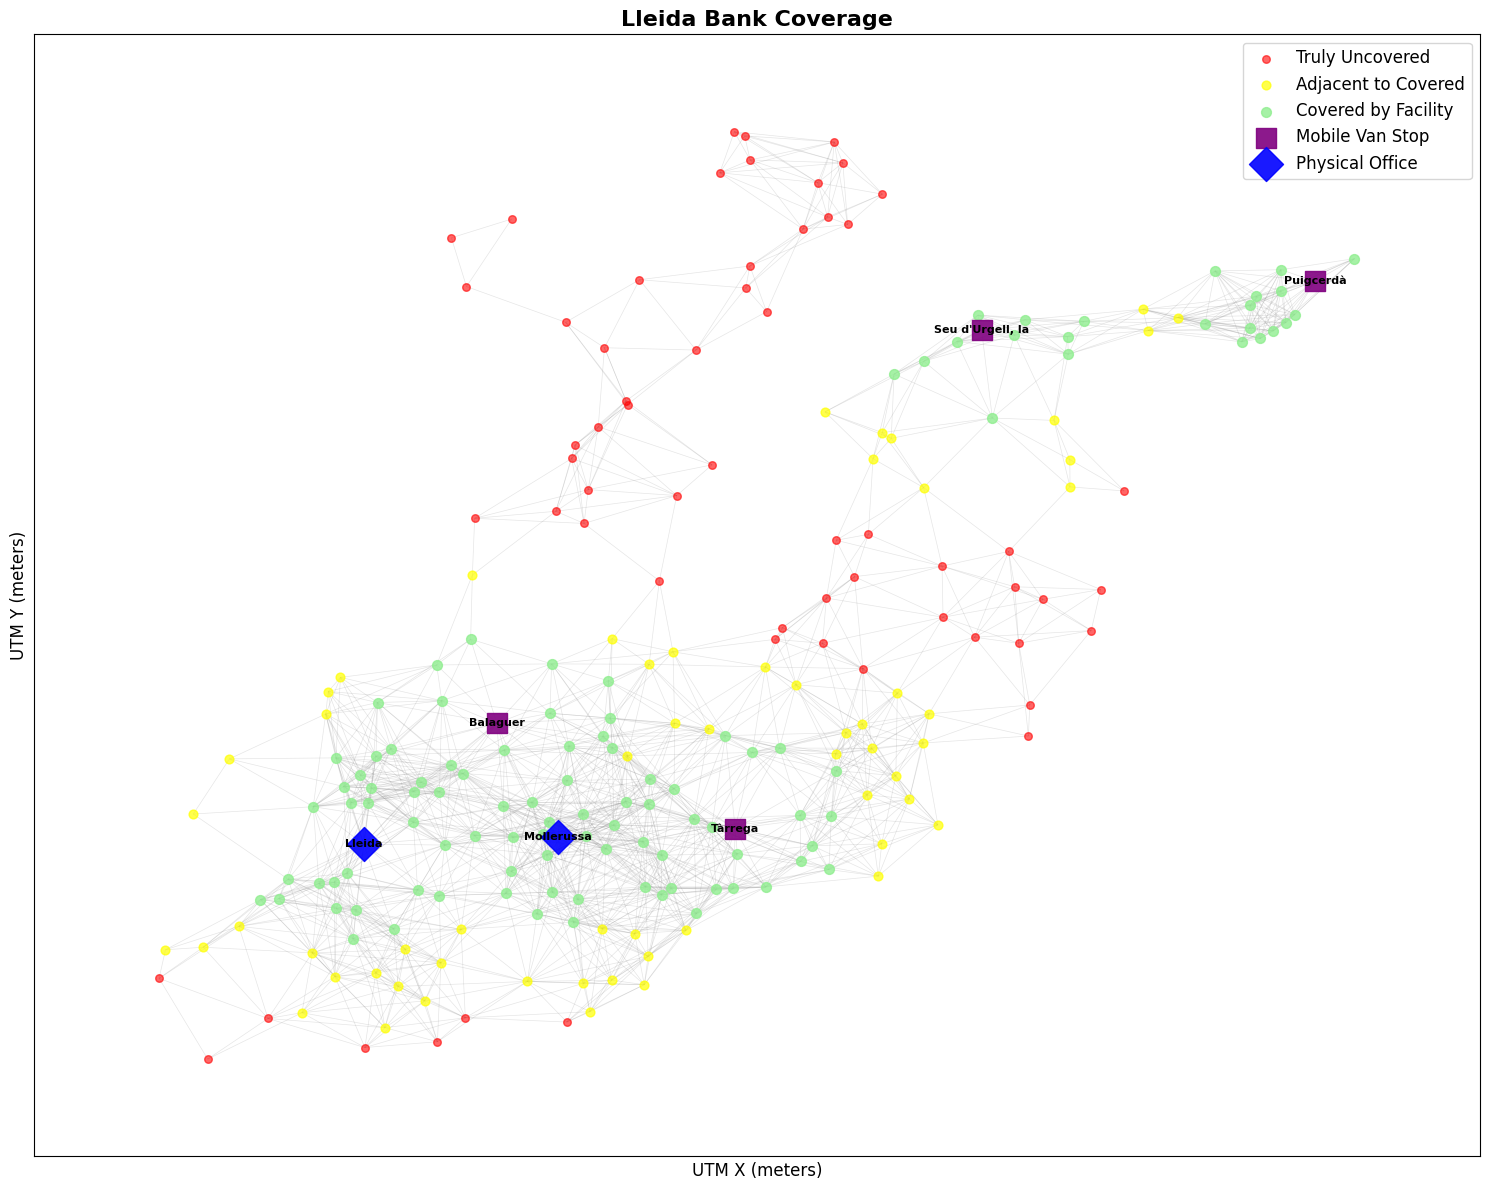



######################################################################
# OPTIMIZING COVERAGE FOR GIRONA
######################################################################


############################################################
# BANK COVERAGE OPTIMIZATION
# Physical Offices: 3
# Mobile Van Stops: 5
############################################################

SELECTING 3 PHYSICAL OFFICE LOCATIONS

  Office 1: Girona (Code: 170792)
    Population: 70,412.989
    Coverage Score: 83,615
    Newly Covered Cities: 34
    Newly Covered Population: 156,472.198
    Total Cities Covered: 34

  Office 2: Figueres (Code: 170669)
    Population: 31,563.687
    Coverage Score: 36,854
    Newly Covered Cities: 49
    Newly Covered Population: 72,993.463
    Total Cities Covered: 83

  Office 3: Lloret de Mar (Code: 170950)
    Population: 27,345.754999999997
    Coverage Score: 33,449
    Newly Covered Cities: 7
    Newly Covered Population: 78,697.04299999999
    Total Cities Covered: 

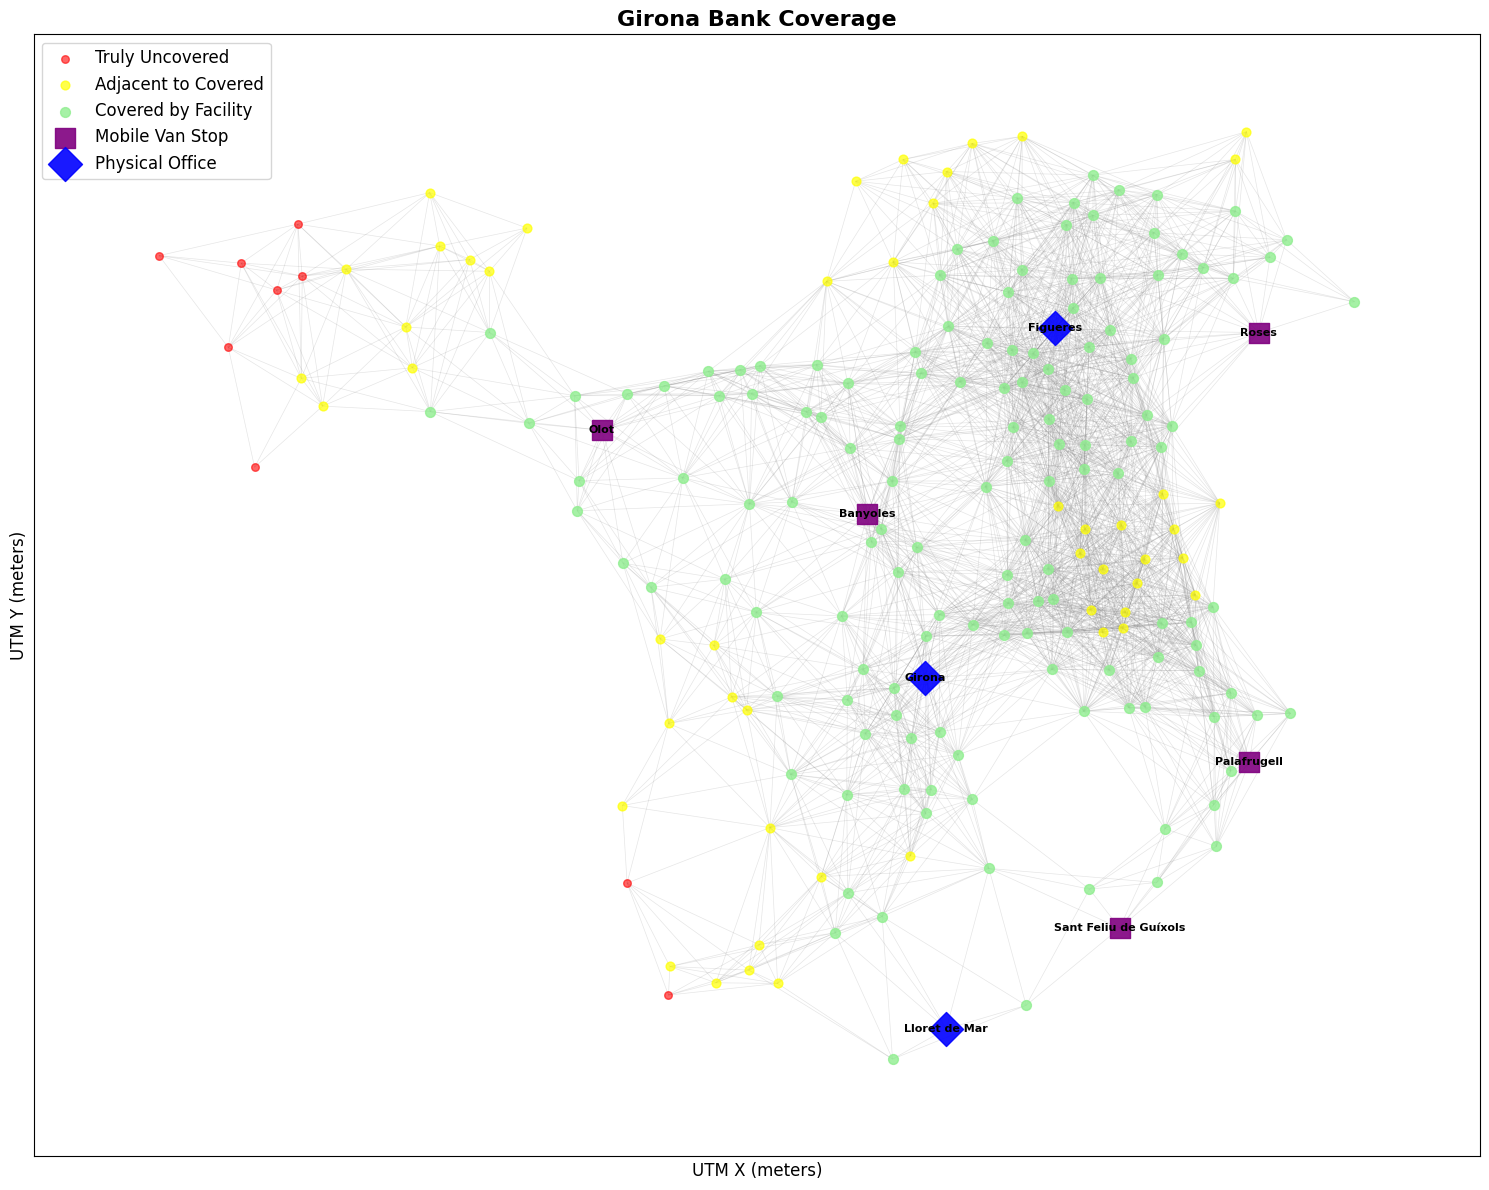



######################################################################
# OPTIMIZING COVERAGE FOR TARRAGONA
######################################################################


############################################################
# BANK COVERAGE OPTIMIZATION
# Physical Offices: 2
# Mobile Van Stops: 4
############################################################

SELECTING 2 PHYSICAL OFFICE LOCATIONS

  Office 1: Tarragona (Code: 431482)
    Population: 90,773.768
    Coverage Score: 105,090
    Newly Covered Cities: 26
    Newly Covered Population: 260,089.143
    Total Cities Covered: 26

  Office 2: Vendrell, el (Code: 431634)
    Population: 24,919.467
    Coverage Score: 34,540
    Newly Covered Cities: 19
    Newly Covered Population: 90,736.568
    Total Cities Covered: 45

SELECTING 4 MOBILE VAN STOP LOCATIONS

  Van Stop 1: Cambrils (Code: 430385)
    Population: 23,093.652
    Coverage Score: 25,801
    Newly Covered Cities: 15
    Newly Covered Population: 48,892

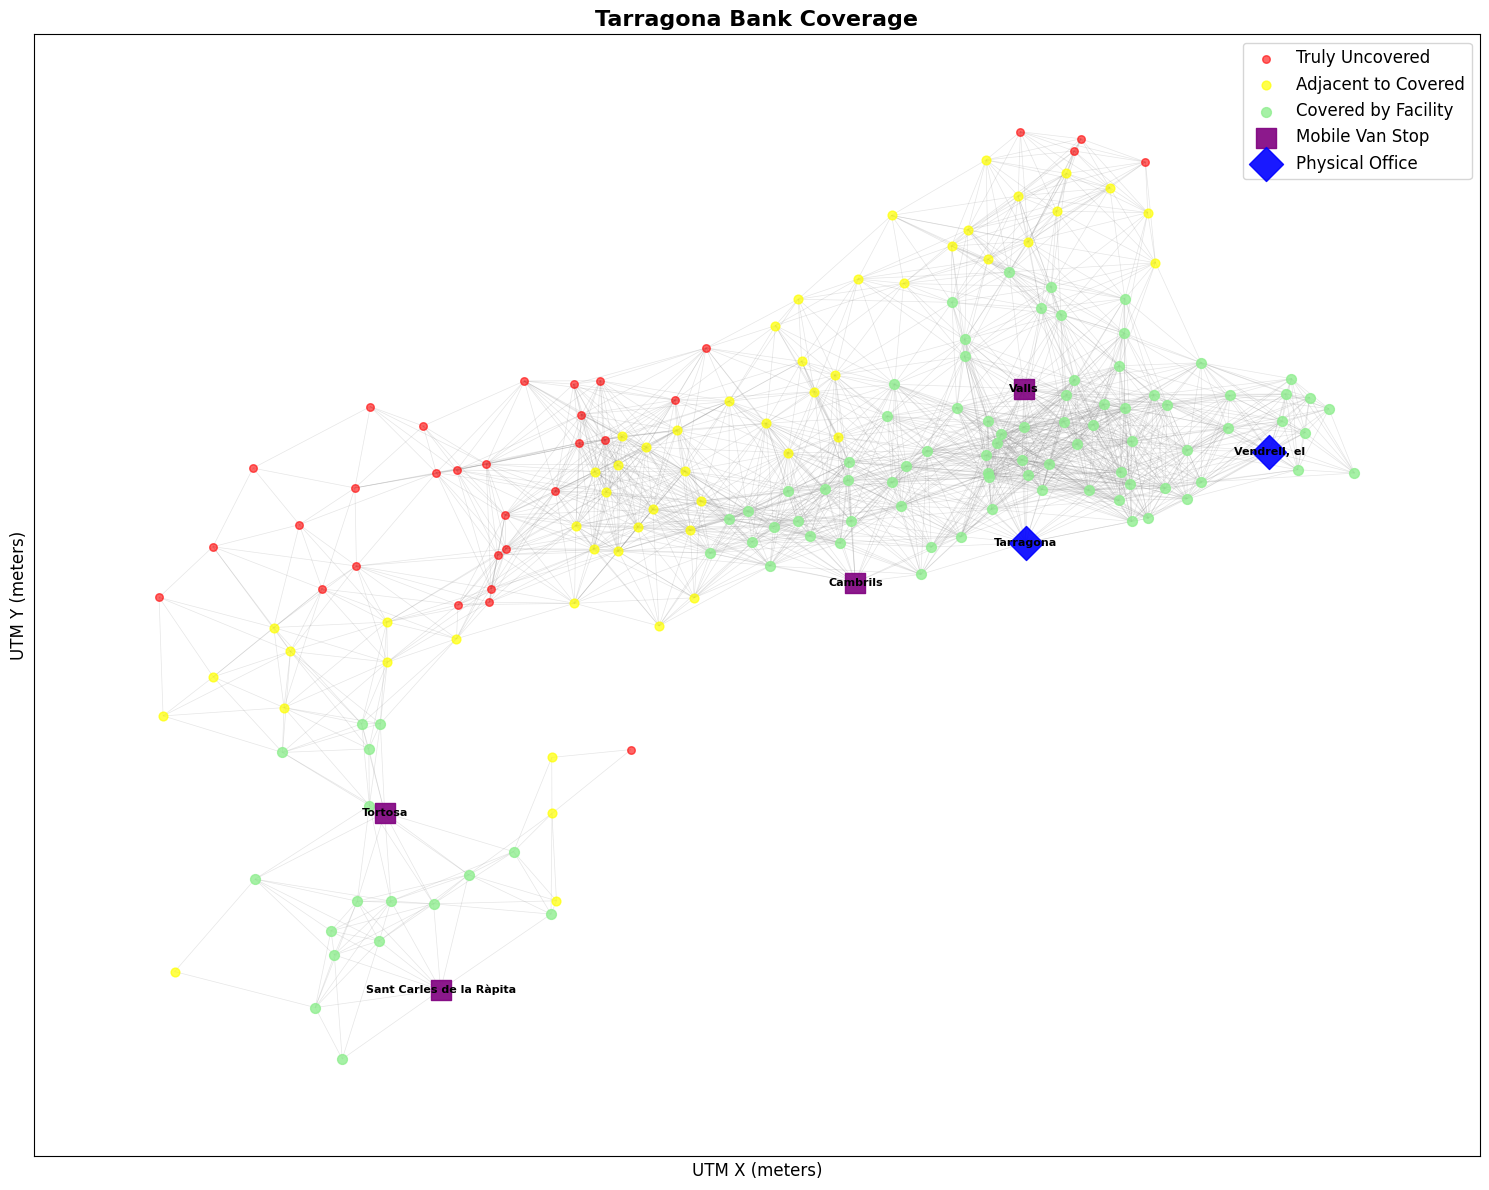

In [85]:
# Example usage with your graphs:

# For Lleida
optimizer_lleida, results_lleida, summary_lleida = optimize_province(
    G_lleida,
    "Lleida",
    num_offices=2,
    num_van_stops=4
)

# For Girona
optimizer_girona, results_girona, summary_girona = optimize_province(
    G_girona,
    "Girona",
    num_offices=3,
    num_van_stops=5
)

# For Tarragona
optimizer_tarragona, results_tarragona, summary_tarragona = optimize_province(
    G_tarragona,
    "Tarragona",
    num_offices=2,
    num_van_stops=4
)

# Convert 'covered_by' list attribute to string before saving to GraphML
for graph in [G_lleida, G_girona, G_tarragona]:
    for node in graph.nodes():
        if 'covered_by' in graph.nodes[node] and isinstance(graph.nodes[node]['covered_by'], list):
            graph.nodes[node]['covered_by'] = ','.join(map(str, graph.nodes[node]['covered_by']))

# Save the modified graphs
nx.write_graphml(G_lleida, 'lleida_optimized.graphml')
nx.write_graphml(G_girona, 'girona_optimized.graphml')
nx.write_graphml(G_tarragona, 'tarragona_optimized.graphml')

# Export summary to CSV
summary_lleida.to_csv('lleida_coverage_summary.csv', index=False)
summary_girona.to_csv('girona_coverage_summary.csv', index=False)
summary_tarragona.to_csv('tarragona_coverage_summary.csv', index=False)
